#Load locally stored data:

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import locale

locale.setlocale(locale.LC_ALL, 'en_US.UTF-8') #This is needed to convert string values of type 1,999.99 
                                               #to float 1999.99

#Define where are the datasets

#Paths for data with market info
#path = os.getcwd()+"/exper_files/datasets/" #Here they are datasets from yahoo
path = os.getcwd()+"/exper_files/coinmarket/" #Here they are datasets from coinmarket

#Paths for data with social info
social_path = os.getcwd()+"/exper_files/social_datasets/cryptocompare/" #Define where are the datasets from cryptocompare

Create the whole dataset:

In [2]:
def dataset_creation(crypto_list, pth, social_pth):
    datasets = {} #Store all datasets here
    social_datasets = {} #Store all datasets with social media information here
    
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    datasets_list = os.listdir(pth) #Find all dataset
    social_datasets_list = os.listdir(social_pth) #Find all dataset with social media information
    
    splitted_path = path.split('/')
    if splitted_path[-2] == 'coinmarket':
        type_of_file = '.txt'
    
    elif splitted_path[-2] == 'datasets':
        type_of_file = '.csv'
        
    
    social_crypto_list = [elem+'.csv' for elem in crypto_list]
    crypto_list = [elem+type_of_file for elem in crypto_list]
    
    
    for dataset in datasets_list:
        if dataset.endswith(type_of_file) and (dataset) in crypto_list:

            name = dataset.split(".")
            dataset_name = name[0]
            
            if splitted_path[-2] == 'datasets':
                
                datasets[dataset_name] = pd.read_csv(pth + dataset) 

                datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date']) #Dataset from yahoo
                                                                                            #is stored ia .csv file.
                    
                datasets[dataset].rename(columns={'Adj Close':dataset+'Adj_Close'}) #Space will cause troubles
                
            
            elif splitted_path[-2] == 'coinmarket':  
                    
                lines = []
                with open(pth + dataset) as f: #Dataset from coinmarket is stored in a .txt file, so we need to read it
                                               #line by line.
                    lines = f.readlines()
                
                initial_columns = lines[0].split("\t") #Split the first line to individual words. The first line 
                                                       #contains the column names. 
                columns = []
                for col in initial_columns:
                    clear_col = col.split('*') #Some column names contains * or **, so we need to exclude them
                    clear_col = clear_col[0].split('\n') #The last element cointains a \n
                    
                    if clear_col[0] == 'Market Cap':
                        clear_col[0] = 'Market_Cap' #Space will cause troubles
                    columns.append(clear_col[0])
                
                df = pd.DataFrame(columns=columns) #Define column names
                
                
                for line in range(1, len(lines)):
                    
                    splitted_line = lines[line].split("\t") #Split each line to individual numbers
                    
                    for elem in range(len(splitted_line)):
                        clear_elem = splitted_line[elem].split('$') #All number cointains a $ (except Date) so we need 
                                                                    #throw it away.
                        
                        if len(clear_elem) == 1:
                            splitted_line[elem] = pd.to_datetime(clear_elem[0])#Tranform each Date to 'datetime' type
                            
                        else:
                            clear_elem[1] = clear_elem[1].split('\n')
                            splitted_line[elem] = locale.atof(clear_elem[1][0])
                    
                    #Append each line to the dataframe
                    row_to_append = pd.Series(splitted_line, index=columns)                    
                    df = df.append(row_to_append, ignore_index=True)
                
                #Invert the sorting of values to ascending based on 'Date'
                df = df.sort_values(by=['Date']).reset_index().drop(['index'], axis=1)
                datasets[dataset_name] = df.copy()
            
            #There are a few missing values, so let fill them with the previous value
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
            
    
    
    #Get social media information for each coin from the corresponding csv
    for dataset in social_datasets_list:
        if dataset.endswith(".csv") and (dataset) in social_crypto_list:
            
            name = dataset.split(".")
            dataset_name = name[0]

            social_datasets[dataset_name] = pd.read_csv(social_pth + dataset) 
            
            social_datasets[dataset_name]['time'] = pd.to_datetime(social_datasets[dataset_name]['time'])
            
            #Drop first column which is an unused index
            social_datasets[dataset_name] = social_datasets[dataset_name].iloc[:, 1:]
            
            #We observed that there are many zero rows at social media datasets.
            #We should find the first row which is non-zero
            res = [next(((j, i) for i, j in enumerate(social_datasets[dataset_name][col]) if j != 0), (0, 0)) 
                   for col in social_datasets[dataset_name] if col != 'time']
            
            #Get all columns except 'time'
            columns_except_time = [col for col in social_datasets[dataset_name].columns if col != 'time']
            
            #Store the index of each column with the first non-zero element
            df_res = pd.DataFrame(res, columns=['value', 'position'], index=columns_except_time)
            
            #Get the minimum of these indices
            first_non_zero_row = df_res['position'].min()

            
            first_date = pd.to_datetime(social_datasets[dataset_name]['time'][first_non_zero_row])
            if first_date >  min_dates[dataset_name]:
                 min_dates[dataset_name] = first_date
                    
            last_date = pd.to_datetime(social_datasets[dataset_name]['time'].iloc[-1])
            if last_date < max_dates[dataset_name]:
                max_dates[dataset_name] = last_date
            
    
    
    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
        
    for dataset in social_datasets:
        social_datasets[dataset] = social_datasets[dataset][(social_datasets[dataset]['time'] >= max_date) & 
                                                            (social_datasets[dataset]['time'] <= min_date)]


    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        
    
    #Drop the first 30 days of 'social_datasets' to be aligned with 'datasets'
    for dataset in social_datasets:
            social_datasets[dataset] = social_datasets[dataset][29:]
          


    #Rename the columns and concatenate all datasets to one 
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        datasets[dataset] = datasets[dataset].rename(columns={dataset+'_Date': 'Date'})                                                   
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1)    
                    
    
    for dataset in social_datasets:
        
        social_datasets[dataset] = social_datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        
        social_datasets[dataset] = ((social_datasets[dataset].drop([dataset+'_time'], axis=1)).reset_index()).drop(['index'], 
                                                                                                          axis=1) 

    
    
    #Concatenate all datasets to one 
    whole_market_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_social_dataset = pd.concat([social_datasets[dataset] for dataset in social_datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_market_dataset, whole_social_dataset], axis=1)
    
   
    return whole_dataset

#Create autocorrelation plot for cryptocurrencies *Close* values.

If the blue line is out of the inner space of dotted lines, then with 95% confidence level there is no significant correlation of *Close* value with time, in the current fraction of time. If so, it means that these values are randomly distributed or they depend on several other factors.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

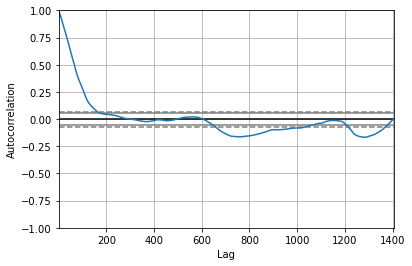

In [7]:
from pandas.plotting import autocorrelation_plot

#Get data
crypto_list = ['BTC-USD', 'ETH-USD', 'DOGE-USD', 'USDT-USD']

data = dataset_creation(crypto_list, path, social_path)
autocorrelation_plot(data['BTC-USD_Close'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

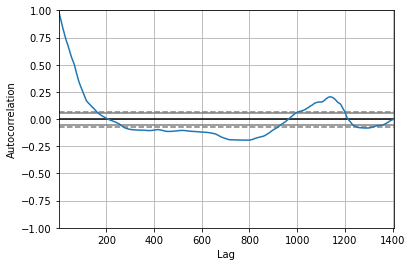

In [8]:
autocorrelation_plot(data['ETH-USD_Close'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

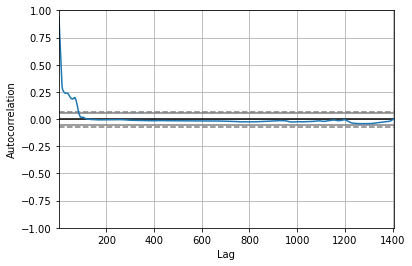

In [9]:
autocorrelation_plot(data['DOGE-USD_Close'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

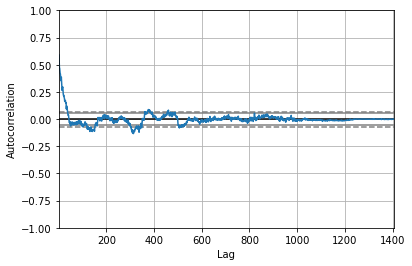

In [10]:
autocorrelation_plot(data['USDT-USD_Close'])

#Perform Augmented Decay-Fuller test to check time series stationarity. 

Stationarity of a time-series is a necessary feature to feed it in a Neural Network. ADF is a type of test which called *union root test* and indicates if there is a trend or pattern in time series and how strong it is.

In [14]:
from statsmodels.tsa.stattools import adfuller
from numpy import log #numpy log is ln

print("ADF for original BTC timeseries:")
X = data['BTC-USD_Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
print("ADF for log transform BTC timeseries")
X = log(data['BTC-USD_Close'].values)
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF for original BTC timeseries:
ADF Statistic: 2.994192
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF for log transform BTC timeseries
ADF Statistic: -0.415931
p-value: 0.907405
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [33]:
#from sklearn.preprocessing import MinMaxScaler

print("ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(-3))-1)/-3

#scaler = MinMaxScaler(feature_range=(0, 1))
#X_transformed = scaler.fit_transform(X.reshape(-1, 1))

result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    

ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: -6.962898
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [16]:
print("ADF for ((y^l)-1)/l, where l=-2, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(-2))-1)/-2
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=-2, transform BTC timeseries
ADF Statistic: -5.740777
p-value: 0.000001
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [17]:
print("ADF for ((y^l)-1)/l, where l=-0.5, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(-0.5))-1)/-0.5
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: -1.848654
p-value: 0.356588
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [18]:
print("ADF for ((y^l)-1)/l, where l=0.5, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(0.5))-1)/0.5
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: 0.661105
p-value: 0.989029
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [19]:
print("ADF for ((y^l)-1)/l, where l=1, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(1))-1)/1
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=1, transform BTC timeseries
ADF Statistic: 2.994192
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [20]:
print("ADF for ((y^l)-1)/l, where l=2, transform BTC timeseries")
X = (((data['BTC-USD_Close'].values)**(2))-1)/2
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for ((y^l)-1)/l, where l=2, transform BTC timeseries
ADF Statistic: 4.462368
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [24]:
#########ETH##############
print("ADF for original ETH timeseries:")
X = data['ETH-USD_Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))



print("ADF for ((y^l)-1)/l, where l=-3, transform ETH timeseries")
X = (((data['ETH-USD_Close'].values)**(-3))-1)/-3
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for original ETH timeseries:
ADF Statistic: 3.051927
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: -3.196823
p-value: 0.020169
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [25]:
#########DOGE########
print("ADF for original DOGE timeseries:")
X = data['DOGE-USD_Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


print("ADF for ((y^l)-1)/l, where l=-3, transform DOGE timeseries")
X = (((data['DOGE-USD_Close'].values)**(-3))-1)/-3
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for original DOGE timeseries:
ADF Statistic: 5.132847
p-value: 1.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF for ((y^l)-1)/l, where l=-3, transform BTC timeseries
ADF Statistic: -2.968138
p-value: 0.037979
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [26]:
#########DOGE########
print("ADF for original USDT timeseries:")
X = data['USDT-USD_Close'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


print("ADF for ((y^l)-1)/l, where l=-3, transform USDT timeseries")
X = (((data['USDT-USD_Close'].values)**(-3))-1)/-3
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF for original USDT timeseries:
ADF Statistic: -4.753400
p-value: 0.000067
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
ADF for ((y^l)-1)/l, where l=-3, transform USDT timeseries
ADF Statistic: -4.787673
p-value: 0.000057
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
